In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.figure_factory as ff
import plotly.express as px
import random
import seaborn as sns
import scipy.stats as stats
import uuid
from cassandra.cluster import Cluster
from datetime import datetime
from io import StringIO
from geopy import Nominatim
from meteostat import Hourly, Stations, Point
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from scipy.fft import dct, idct


In [2]:
# connecting to MongoDB 
url = (
    "mongodb+srv://medvetslos:"
    + json.load(open("../../.nosync/mongoDB.json"))["pwd"]
    + "@ind320-project.lunku.mongodb.net/?retryWrites=true&w=majority&appName=IND320-project"
)

mdb_client = MongoClient(url, server_api=ServerApi("1"))

try:
    mdb_client.admin.command("ping")
    print("Pinged your deployment. Successfully connected to MongoDB.")
except Exception as exceptionMsg:
    print(exceptionMsg)

database = mdb_client["IND320-project"]
municipalities = database["municipalities"]

Pinged your deployment. Successfully connected to MongoDB.


In [3]:
# Set environment variables to make PySpark work
os.environ["JAVA_HOME"] = "/opt/homebrew/opt/openjdk@11/"
os.environ["PYSPARK_PYTHON"] = "python" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "python" 
os.environ["PYSPARK_HADOOP_VERSION"] = "without"

# Spark set up
spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').\
    config("spark.driver.memory", "4g").\
    config("spark.executor.memory", "4g").\
    config("spark.task.maxFailures", "10").\
    config("spark.sql.shuffle.partitions", "200").\
    getOrCreate()

keyspace = "ind320_project"

24/10/24 11:16:30 WARN Utils: Your hostname, Aarons-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.11.110 instead (on interface en0)
24/10/24 11:16:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Users/aaron/.ivy2/cache
The jars for the packages stored in: /Users/aaron/.ivy2/jars
com.datastax.spark#spark-cassandra-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-2a0552f4-6843-4b8d-bb4e-5aa4b351b8e6;1.0
	confs: [default]
	found com.datastax.spark#spark-cassandra-connector_2.12;3.4.1 in central
	found com.datastax.spark#spark-cassandra-connector-driver_2.12;3.4.1 in central
	found org.scala-lang.modules#scala-collection-compat_2.12;2.11.0 in central
	found com.datastax.oss#java-driver-core-shaded;4.13.0 in central


:: loading settings :: url = jar:file:/Users/aaron/Documents/IND320_projects/.venv/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found com.datastax.oss#native-protocol;1.5.0 in central
	found com.datastax.oss#java-driver-shaded-guava;25.1-jre-graal-sub-1 in central
	found com.typesafe#config;1.4.1 in central
	found org.slf4j#slf4j-api;1.7.26 in central
	found io.dropwizard.metrics#metrics-core;4.1.18 in central
	found org.hdrhistogram#HdrHistogram;2.1.12 in central
	found org.reactivestreams#reactive-streams;1.0.3 in central
	found com.github.stephenc.jcip#jcip-annotations;1.0-1 in central
	found com.github.spotbugs#spotbugs-annotations;3.1.12 in central
	found com.google.code.findbugs#jsr305;3.0.2 in central
	found com.datastax.oss#java-driver-mapper-runtime;4.13.0 in central
	found com.datastax.oss#java-driver-query-builder;4.13.0 in central
	found org.apache.commons#commons-lang3;3.10 in central
	found com.thoughtworks.paranamer#paranamer;2.8 in central
	found org.scala-lang#scala-reflect;2.12.11 in central
:: resolution report :: resolve 206ms :: artifacts dl 6ms
	:: modules in use:
	com.datastax.oss#java-d

In [4]:
cluster = Cluster(["localhost"], port=9042)
session = cluster.connect()
keyspace = "ind320_project"

# Creating a keyspace in Cassandra
session.execute(
    "CREATE KEYSPACE IF NOT EXISTS" + 
    " " + 
    keyspace + 
    " " + 
    "WITH REPLICATION = {'class': 'SimpleStrategy', 'replication_factor': 1};"
)

session.set_keyspace(keyspace)

In [5]:
def create_cassandra_view(view_name:str, table_name: str, keyspace_name: str):
    spark.read.format("org.apache.spark.sql.cassandra")\
        .options(table=table_name, keyspace=keyspace_name)\
        .load()\
        .createOrReplaceTempView(view_name)
    print(f"View '{view_name}' created.")

def create_cassandra_table_query(df, new_table_name, keyspace_name):
    # Define mapping between Pandas and Cassandra datatypes
    dtype_mapping = {
        'int64': 'int',
        'float64': 'double',
        'object': 'text',
        'bool': 'boolean',
        'datetime64[ns]': 'timestamp'
    }
    
    # Start constructing the CREATE TABLE query
    query = f"CREATE TABLE IF NOT EXISTS {keyspace_name}.{new_table_name} (\n"
    
    # Add primary key column with timeuuid
    columns = ["id timeuuid"]
    
    # Add remaining columns with mapped Cassandra data types
    for col, dtype in df.dtypes.items():
        if col != "id":  # Exclude 'id' to avoid duplication
            cassandra_type = dtype_mapping.get(str(dtype), 'text')  # Default to 'text' if type is unrecognized
            columns.append(f"{col} {cassandra_type}")
    
    # Join columns with commas and specify primary key as 'id'
    columns_str = ",\n    ".join(columns)
    query += f"    {columns_str},\n"
    query += "    PRIMARY KEY (id)\n);"
    
    return query

def insert_to_cassandra(df: pd.DataFrame , table_name: str, keyspace_name: str): 
# Prompt: How can I add a timeuuid 'id' column when inserting into Cassandra with PySpark
    def generate_timeuuid():
        return str(uuid.uuid1())
    
    timeuuid_udf = udf(generate_timeuuid, StringType())
    spark.createDataFrame(df).withColumn("id", timeuuid_udf())\
        .write.format("org.apache.spark.sql.cassandra")\
        .mode("append")\
        .options(table=table_name, keyspace=keyspace_name)\
        .save()
    
    print("Insertion completed!")

### Geographical locations of municipalities

In [10]:
price_areas = {
    "DK1": ["Zealand", "Capital"],
    "DK2": ["North", "Central", "South"]
}

In [7]:
nominatim = Nominatim(user_agent="personal-application") # Initialize a geocoder
region_municipality = municipalities.find({}, {"Region": 1, "Municipality": 1})

for row in region_municipality: 
    _id = row["_id"]

    # Set price area
    if row["Region"] in price_areas["DK2"]:
        price_area = "DK2"
    else: 
        price_area = "DK1"

    # Find longitude and latitude of the municipality
    geocode_location = nominatim.geocode(row["Municipality"] + " kommune")
    longitude = geocode_location.longitude
    latitude = geocode_location.latitude

    # Update the row entry with values for the new entry 
    update_template = {
        "$set": {
            "Price Area": price_area,
            "Longitude": longitude,
            "Latitude": latitude
        }
    }

    municipalities.update_one({"_id": _id}, update_template)

In [11]:
from datetime import datetime
from meteostat import Hourly

# Set time period
start = datetime(2018, 1, 1)
end = datetime(2018, 12, 31, 23, 59)

# Get hourly data
data = Hourly('72219', start, end)
data_1 = data.fetch()

# Print DataFrame
print(data_1)

                     temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt    pres  \
time                                                                           
2018-01-01 00:00:00   0.6  -5.6  63.0   NaN   NaN  340.0  18.4   NaN  1024.6   
2018-01-01 01:00:00  -1.1  -6.6  66.0   0.0   NaN  320.0  16.6   NaN  1025.4   
2018-01-01 02:00:00  -1.1  -9.5  53.0   0.0   NaN  330.0  22.3   NaN  1025.8   
2018-01-01 03:00:00  -1.1 -10.0  51.0   0.0   NaN  330.0  25.9   NaN  1025.6   
2018-01-01 04:00:00  -1.7 -10.5  51.0   0.0   NaN  340.0  18.4   NaN  1026.1   
...                   ...   ...   ...   ...   ...    ...   ...   ...     ...   
2018-12-31 19:00:00  20.0  17.2  84.0   0.0   NaN  200.0  18.4   NaN  1016.5   
2018-12-31 20:00:00  21.1  16.7  76.0   0.0   NaN  190.0  22.3   NaN  1015.8   
2018-12-31 21:00:00  21.1  16.1  73.0   0.0   NaN  180.0  27.7   NaN  1014.7   
2018-12-31 22:00:00  21.1  15.0  68.0   0.0   NaN  190.0  27.7   NaN  1015.7   
2018-12-31 23:00:00  20.0  15.0  73.0   

In [16]:
data.stations

Index(['72219'], dtype='object')

### Weather data

In [18]:
start = datetime(2022, 1, 1)
end = datetime(2022, 12, 31, 23, 59)
stations = Stations()

df_weather = pd.DataFrame()

municipality_coords = municipalities.find({}, {"Municipality": 1, "Longitude": 1, "Latitude": 1})

for row in municipality_coords:
    latitude = row["Latitude"]
    longitude = row["Longitude"]
    nearby_stations = stations.nearby(latitude, longitude)
    nearest_station = nearby_stations.fetch(1) # Fetches nearest station to the coordinates given 
    distance = nearest_station["distance"].iloc[0] # Returns distance to nearest station
    
    weather_location = Hourly(Point(latitude, longitude), start, end)
    weather_data = weather_location.fetch() # Retrieves hourly weather data for specified period
    weather_data["distance"] = distance
    weather_data["municipality"] = row["Municipality"] # Adding a "municipality" so we can distinguish the data 

    df_weather = pd.concat([df_weather, weather_data])

df_weather = df_weather.reset_index()
df_weather = df_weather.rename(columns={"index": "datetime"})

In [9]:
cas_weather_table = "weather_data"
session.execute(f"DROP TABLE IF EXISTS {keyspace}.{cas_weather_table}")
weather_table = create_cassandra_table_query(df_weather, cas_weather_table, keyspace)
session.execute(weather_table)
insert_to_cassandra(df_weather, cas_weather_table, keyspace)

24/10/23 13:08:05 WARN TaskSetManager: Stage 0 contains a task of very large size (8194 KiB). The maximum recommended task size is 1000 KiB.


Insertion completed!


### Smoothing and outliers/anomalies

#### Gas prices

In [6]:
gas_prices = [entry for entry in database["gas"].find({}, {"PurchasePriceDKK_kWh": 1, "GasDay": 1})]
df_gas_prices = pd.DataFrame.from_records(gas_prices)
df_gas_prices = df_gas_prices.sort_values("GasDay", ascending=True)
df_gas_prices.head()

,_id,GasDay,PurchasePriceDKK_kWh
91,6709103c43f4e1efbf67a110,2022-10-01,1.2209
90,6709103c43f4e1efbf67a10f,2022-10-02,1.1672
89,6709103c43f4e1efbf67a10e,2022-10-03,1.0476
88,6709103c43f4e1efbf67a10d,2022-10-04,0.8667
87,6709103c43f4e1efbf67a10c,2022-10-05,0.6087


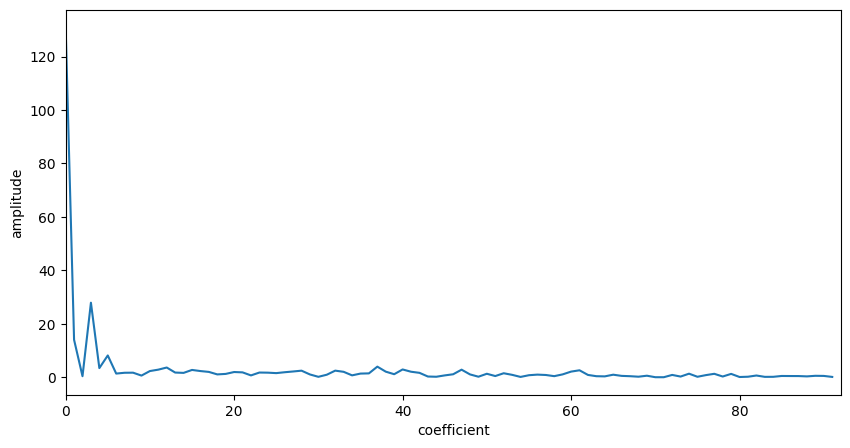

In [11]:
W = np.arange(0, df_gas_prices.shape[0])
dct_gas_prices = dct(df_gas_prices["PurchasePriceDKK_kWh"].values) # DCT on the gas prices

plt.figure(figsize=(10, 5))
plt.plot(np.abs(dct_gas_prices))
plt.xlabel('coefficient') 
plt.ylabel('amplitude')
plt.xlim(0, dct_gas_prices.shape[0])
plt.show()

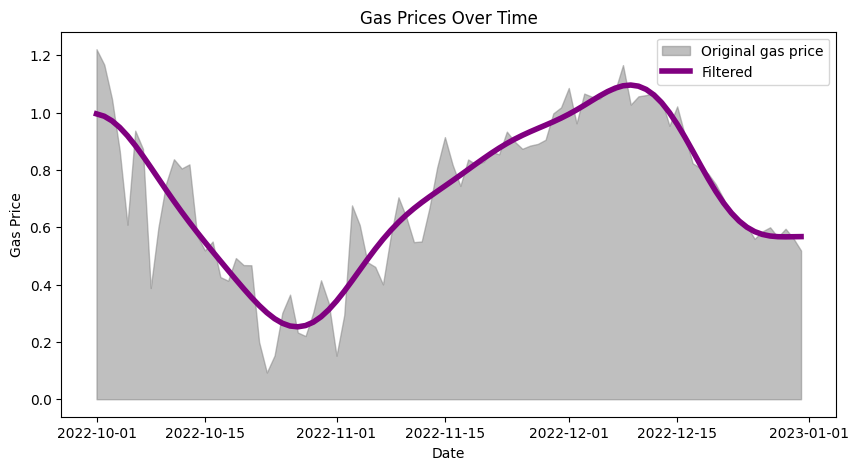

In [12]:
dct_gas_prices[(W > 10)] = 0


plt.figure(figsize=(10, 5))
plt.fill_between(df_gas_prices['GasDay'], df_gas_prices['PurchasePriceDKK_kWh'], 
                 color='grey', alpha=0.5, label="Original gas price")
plt.xlabel('Date')
plt.ylabel('Gas Price')
plt.title('Gas Prices Over Time')
plt.plot(df_gas_prices['GasDay'], idct(dct_gas_prices), label="Filtered",
         color="purple", linewidth=4)
plt.legend()
plt.show()

#### Electricity exchange

In [13]:
create_cassandra_view("prodcons_view", "prodcons", keyspace)  # Create a view to access the Cassandra table
df_exchangeNO = spark.sql("SELECT hourdk, exchangeno_mwh FROM prodcons_view").toPandas()
df_exchangeNO = df_exchangeNO.groupby("hourdk").aggregate({"exchangeno_mwh": "sum"}) # Aggregate sum to ensure I only have one observation each hour

# Mean and standard deviation of the electricity exchange
mean_exchangeNO = df_exchangeNO["exchangeno_mwh"].mean()
std_exchangeNO = df_exchangeNO["exchangeno_mwh"].std()
print(f"Mean: {mean_exchangeNO:.3f}, Standard deviation: {std_exchangeNO:.3f}")

# Robust statistics
trim_mean_exchangeNO = stats.trim_mean(df_exchangeNO["exchangeno_mwh"], 0.05)
MAD_exchangeNO = stats.median_abs_deviation(df_exchangeNO["exchangeno_mwh"])
print(f"Trimmed mean: {trim_mean_exchangeNO:.3f}, MAD: {MAD_exchangeNO:.3f}")
print(f"Estimated standard deviation from MAD: {MAD_exchangeNO * 1.4826:.3f}")

24/10/23 13:08:25 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


View 'prodcons_view' created.
Mean: 228.552, Standard deviation: 1012.995
Trimmed mean: 256.473, MAD: 694.875
Estimated standard deviation from MAD: 1030.222


*DISCUSS NUMBERINOS*

Trimmed mean is different from the mean statistic as we remove a percentage of the most extreme outliers, here 5%. 

Median absolute devation differs from standard deviation, but it has a relation to it by multiplying it by $k \approx 1.4826$. By multiplying by $k$ we get a value more similair to the standard deviation $\hat{\sigma}$ approximated above.

<Figure size 1000x500 with 0 Axes>

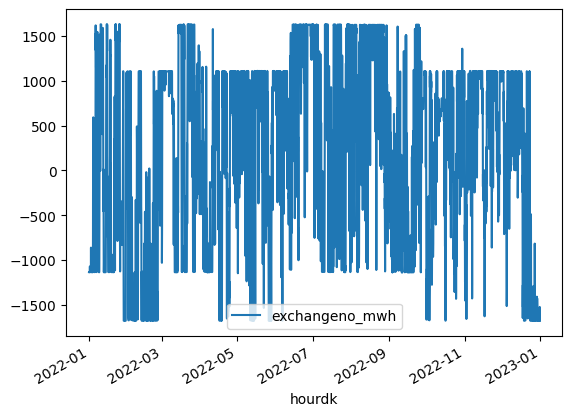

In [14]:
plt.figure(figsize=(10,5))
df_exchangeNO.plot()
plt.show()

In [15]:
# SPC
# According to SPC, observations outside $\pm 3$ standard deviations of the mean are considered outliers.
lower_threshold = mean_exchangeNO - std_exchangeNO * 3
upper_threshold =  mean_exchangeNO + std_exchangeNO * 3
print(lower_threshold, upper_threshold)

# plt.figure(figsize=(10, 5))

-2810.4330951104407 3267.5362585775033


### Imputation

Vi skal sikkert bruke nærliggende stasjoner for å impute verdier?

In [6]:
gas_prices = [entry for entry in database["gas"].find({}, {"PurchasePriceDKK_kWh": 1, "GasDay": 1})]
# Create views to access the Cassandra tables
create_cassandra_view("prodcons_view", "prodcons", keyspace)  
create_cassandra_view("production_view", "production", keyspace)
create_cassandra_view("consumption_view", "consumption", keyspace)
create_cassandra_view("weather_view", "weather_data", keyspace)

# Retrieve and prepare dataframes
df_municipalities = pd.DataFrame.from_records([entry for entry in municipalities.find({})]) 
df_gas_prices = pd.DataFrame.from_records(gas_prices)
df_prodcons = spark.sql("SELECT * FROM prodcons_view").toPandas()
df_production = spark.sql("SELECT * FROM production_view").toPandas()
df_consumption = spark.sql("SELECT * FROM consumption_view").toPandas()
df_weather_data = spark.sql("SELECT * FROM weather_view").toPandas()

24/10/24 11:16:38 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


View 'prodcons_view' created.
View 'production_view' created.
View 'consumption_view' created.
View 'weather_view' created.


#### Checking for missing values in each dataframe

In [17]:
dfs = {"gas_prices": df_gas_prices, "prodcons": df_prodcons, 
       "production": df_production, "consumption": df_consumption, 
       "weather_data": df_weather_data, "municipalities": df_municipalities}

for key, df in dfs.items():
    na_df = df.isna().sum()
    non_zero_na_df = na_df[na_df > 0]

    if not non_zero_na_df.empty:
       print(f"\n{key} - {df.shape}:")
       print(non_zero_na_df)


prodcons - (17520, 29):
exchangegb_mwh    17520
exchangenl_mwh     8760
exchangeno_mwh     8760
dtype: int64

production - (871393, 9):
offshorewindge100mw_mwh    818834
offshorewindlt100mw_mwh    801313
solarmwh                     8760
thermalpowermwh            123888
dtype: int64

weather_data - (762120, 15):
coco     48361
dwpt      2658
prcp    158466
pres      2658
rhum      2658
snow    718431
temp      2658
tsun    720638
wdir      2661
wpgt      2723
wspd      2658
dtype: int64


In [8]:
def na_overview(df: pd.DataFrame):
    na_df = df.isna().sum()
    na_df = na_df[na_df > 0].to_frame(name="# missing values")
    na_df["% missing values"] = na_df["# missing values"] / df.shape[0]
    return na_df

##### Prodcons

In [29]:
na_prodcons = na_overview(df_prodcons)
na_prodcons

,# missing values,% missing values
exchangegb_mwh,17520,1.0
exchangenl_mwh,8760,0.5
exchangeno_mwh,8760,0.5


In [20]:
# Trying to assess a pattern 
df_prodcons_na = df_prodcons[["hourdk", "pricearea", "exchangeno_mwh", 
                              "exchangenl_mwh", "exchangegb_mwh"]].copy()
df_prodcons_na = df_prodcons_na.sort_values("hourdk", ascending=True)
df_prodcons_na.head(8)

,hourdk,pricearea,exchangeno_mwh,exchangenl_mwh,exchangegb_mwh
5940,2022-01-01 00:00:00,DK1,-1131.8420,-621.410,NaN
10985,2022-01-01 00:00:00,DK2,NaN,NaN,NaN
13926,2022-01-01 01:00:00,DK1,-1132.2717,-583.754,NaN
10470,2022-01-01 01:00:00,DK2,NaN,NaN,NaN
7652,2022-01-01 02:00:00,DK2,NaN,NaN,NaN
4437,2022-01-01 02:00:00,DK1,-1132.2246,-554.725,NaN
10461,2022-01-01 03:00:00,DK1,-1132.4853,-237.741,NaN
1616,2022-01-01 03:00:00,DK2,NaN,NaN,NaN


In [21]:
# Checking if the Netherlands and Norway only exchange energy with pricearea DK2
# If they happen to do so, we should see False print outs
print(df_prodcons[df_prodcons["exchangeno_mwh"].notna()].query("pricearea == 'DK2'").empty)
print(df_prodcons[df_prodcons["exchangenl_mwh"].notna()].query("pricearea == 'DK2'").empty)

True
True


For **prodcons** we have missing data for the exchange of energy to Great Britain, the Netherlands and Norway. Great Britain has no import or export of energy during the period of our data, hence 17520 total missing values. For both the Netherlands and Norway we have half of the missing values as Great Britain. This can be attributed to these countries only exchanging energy with `pricearea` "DK1".

Imputing any of these missing values would not be appropriate.

##### Production

In [19]:
df_production.shape

(871393, 8)

In [22]:
na_production = na_overview(df_production)
na_production

,# missing values,% missing values
offshorewindge100mw_mwh,818834,0.939684
offshorewindlt100mw_mwh,801313,0.919577
solarmwh,8760,0.010053
thermalpowermwh,123888,0.142172


**production** is missing quite a lot of data in its offshore wind production, missing >90% of data from an eyeball estimation. Imputing this amount of data would be unreasonable.

However, solar and thermal energy production are missing less data which would be more feasible to impute.

In [24]:
create_cassandra_view("production_view", "production", keyspace)  
df_production = spark.sql("SELECT * FROM production_view").toPandas()
df_production = df_production.sort_values("hourdk", ascending=True)
df_production.set_index("hourdk", inplace=True)

# Original values
solarpowermwh_og = df_production["solarmwh"].dropna().values
thermalpowermwh_og = df_production["thermalpowermwh"].dropna().values

# Interpolating missing values ("time" for now because it doesn't take long)
df_production["solarmwh"] = df_production["solarmwh"].interpolate("time")
df_production["thermalpowermwh"] = df_production["thermalpowermwh"].interpolate("time")

# Interpolated values
solarpowermwh_imputed = df_production["solarmwh"].values
thermalpowermwh_imputed = df_production["thermalpowermwh"].values

df_production.reset_index(inplace=True)

View 'production_view' created.


In [26]:
# plt.figure(figsize=(12, 6))
# sns.kdeplot(solarpowermwh_og, label='Original Solar MWh', color='blue')
# sns.kdeplot(solarpowermwh_imputed, label='Interpolated Solar MWh', color='orange')
# plt.title('KDE of Original vs Interpolated Solar MWh')
# plt.legend()
# plt.show()

# # Plotting KDE for thermalpowermwh
# plt.figure(figsize=(12, 6))
# sns.kdeplot(thermalpowermwh_og, label='Original Thermal Power MWh', color='green')
# sns.kdeplot(thermalpowermwh_imputed, label='Interpolated Thermal Power MWh', color='red')
# plt.title('KDE of Original vs Interpolated Thermal Power MWh')
# plt.legend()
# plt.show()

In [32]:
na_production_imp = na_overview(df_production)
na_production_imp

,# missing values,% missing values
offshorewindge100mw_mwh,818834,0.939684
offshorewindlt100mw_mwh,801313,0.919577


##### **VIL LAGE LIGNENDE PLOTS**

<Axes: xlabel='hourdk'>

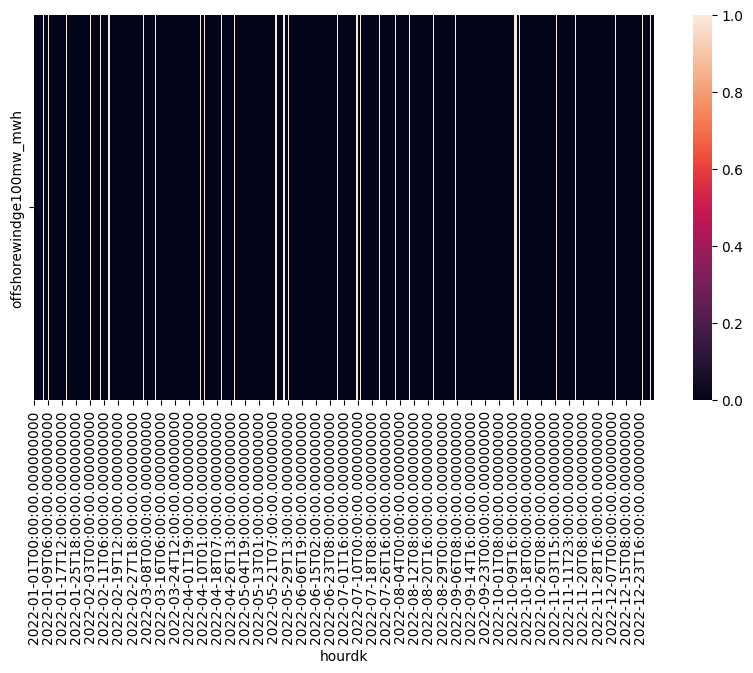

In [25]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.heatmap(df_production[["offshorewindge100mw_mwh"]].notnull().T) 

##### Weather data

In [9]:
na_weather = na_overview(df_weather_data)
na_weather

,# missing values,% missing values
coco,48361,0.063456
dwpt,2658,0.003488
prcp,158466,0.207928
pres,2658,0.003488
rhum,2658,0.003488
snow,718431,0.942674
temp,2658,0.003488
tsun,720638,0.945570
wdir,2661,0.003492
wpgt,2723,0.003573


`dwpt`, `pres`, `rhum`, and `wspd` are missing the same amount of data.

In [10]:
# Finding the stations where "snow" and "tsun" is being measured to assess
# why there are many missing values
print(df_weather_data[df_weather_data["snow"].notna()]["municipality"].unique())
print(df_weather_data[df_weather_data["tsun"].notna()]["municipality"].unique())

['Sønderborg' 'Ærø' 'Lolland' 'Aabenraa' 'Tønder']
['Sønderborg' 'Ærø' 'Lolland' 'Aabenraa' 'Tønder']


In [14]:
# Check if there are any missing values for the locations which measures `snow` and `tsun`
tsun_snow_locations = df_weather_data[df_weather_data["tsun"].notna()]["municipality"].unique()
df_tsun_snow = df_weather_data[df_weather_data["municipality"].isin(tsun_snow_locations)]
df_tsun_snow.isna().sum()[df_tsun_snow.isna().sum() > 0] # endre på denne

snow     111
tsun    2318
dtype: int64

In [15]:
# Checking if there any stations that does not measure precipitation
na_prcp = set(df_weather_data[df_weather_data["prcp"].notna()]["municipality"].unique())^\
    set(df_weather_data["municipality"].unique()) # ^ - symmetric difference operator. Between two sets, it returns values not shared by both sets.

print(na_prcp)

{'Morsø', 'Lemvig', 'Helsingør', 'Struer', 'Halsnæs', 'Odsherred', 'Skive', 'Gribskov', 'Thisted', 'Vesthimmerland'}


**weather_data** is missing a lot of data for `snow` which at first glance is sensible since there isn't snow all year round. But upon further investigation, `snow` is only measured at a handful of stations. This is also the case for `tsun` which is measured at the same stations, hence the big number of missing values. Having to impute this for the rest of the stations would be unreasonable as no measurements exists at these locations. 

The missing values for `prcp` is partly due to 10 stations not measuring percipitation at all. Imputing the precipitation for these stations would not make sense. The remaining missing values comes from stations which do measure percipitation and these we can impute.

`dwpt`, `pres`, `rhum`, and `wspd` are missing the same amount of data.

For the remaining fetures it would be reasonable to impute the missing values as the numbers are relatively small.

In [92]:
df_weather_data = spark.sql("SELECT * FROM weather_view").toPandas()

# Preparing DataFrame for interpolation
df_weather_data = df_weather_data.sort_values("datetime", ascending=True)
df_weather_data.set_index("datetime", inplace=True)


,# missing values,% missing values
snow,718320,0.942529
tsun,718320,0.942529


In [ ]:
# Impute `prcp` for everything but 'Aabenraa' 'Tønder' 'Lolland' 'Sønderborg' 'Ærø'
exclude_list = list(na_prcp)
df_weather_data_prcp = df_weather_data[~df_weather_data["municipality"].isin(exclude_list)].copy() # Excluding municipalities/weather stations that does not measure precipitation
df_weather_data_prcp["prcp"] = df_weather_data_prcp["prcp"].interpolate("time") 
df_weather_data.loc[~df_weather_data["municipality"].isin(exclude_list), ["prcp"]] = df_weather_data_prcp["prcp"].values 

df_weather_data.reset_index()

### Synchronization

Make a function that takes an hourly time series for a selected weather property for a selected municipality as input (and relevant parameters/descriptors) and resamples it into daily values matching the gas prices for part 1 of the project work.

Design question: Do we assume that one time series has hourly and another daily measurements?

- Check latest starting point of each series
- Limit series to start latest starting point of two series
- Aggregate to calculate daily mean values of columns (time column excluded ofc)

In [104]:
# Endre på denne til å kun returnere en dataframe med de to tingene vi ønsker å få ut!

def sync_weather_to_gas(weather_df: pd.DataFrame, gas_df: pd.DataFrame, 
                        time_weather: str, time_gas: str, 
                        weather_property: str, accumulation_mtd: str = "mean"):
    weather_df = weather_df.sort_values(time_weather, ascending=True)
    gas_df = gas_df.sort_values(time_gas, ascending=True)

    # Preparation for aggregation
    weather_df = weather_df[[time_weather, weather_property]]

    weather_df.set_index(time_weather, inplace=True)
    gas_df.set_index(time_gas, inplace=True)

    weather_df = weather_df.drop(labels="id", axis=1)

    # Aggregate weather_df to daily frequency w.r.t. accumulation method
    if accumulation_mtd == "mean":
          weather_df = weather_df.groupby("municipality").resample("D").mean()

    weather_df.reset_index(inplace=True)
    gas_df.reset_index(inplace=True)

    # Determining start point
    series_start = max(gas_df[time_gas].min(), weather_df[time_weather].min())

    # Determining end point
    series_end = min(gas_df[time_gas].max(), weather_df[time_weather].max())

    # Shortening the time series'
    weather_df = weather_df[(weather_df[time_weather] >= series_start) & (weather_df[time_weather] <= series_end)]
    gas_df = gas_df[(gas_df[time_gas] >= series_start) & (gas_df[time_gas] <= series_end)]

    # return weather_df, gas_df
    return weather_df, gas_df 

In [ ]:
# Endre på denne til å kun returnere en dataframe med de to tingene vi ønsker å få ut!

def sync_weather_to_gas(weather_df: pd.DataFrame, gas_df: pd.DataFrame, 
                        time_weather: str, time_gas: str, 
                        weather_property: str, accumulation_mtd: str = "mean"):
    weather_df = weather_df.sort_values(time_weather, ascending=True)
    gas_df = gas_df.sort_values(time_gas, ascending=True)

    # Preparation for aggregation
    weather_df = weather_df[[time_weather, weather_property]]

    weather_df.set_index(time_weather, inplace=True)
    gas_df.set_index(time_gas, inplace=True)

    weather_df = weather_df.drop(labels="id", axis=1)

    # Aggregate weather_df to daily frequency w.r.t. accumulation method
    if accumulation_mtd == "mean":
          weather_df = weather_df.groupby("municipality").resample("D").mean()

    weather_df.reset_index(inplace=True)
    gas_df.reset_index(inplace=True)

    # Determining start point
    series_start = max(gas_df[time_gas].min(), weather_df[time_weather].min())

    # Determining end point
    series_end = min(gas_df[time_gas].max(), weather_df[time_weather].max())

    # Shortening the time series'
    weather_df = weather_df[(weather_df[time_weather] >= series_start) & (weather_df[time_weather] <= series_end)]

    # return weather_df, gas_df
    return weather_df

In [ ]:
df_weather_trunc, df_gas_prices_trunc = sync_weather_to_gas(df_weather_data, df_gas_prices,
                                                            "datetime", "GasDay", "temp")

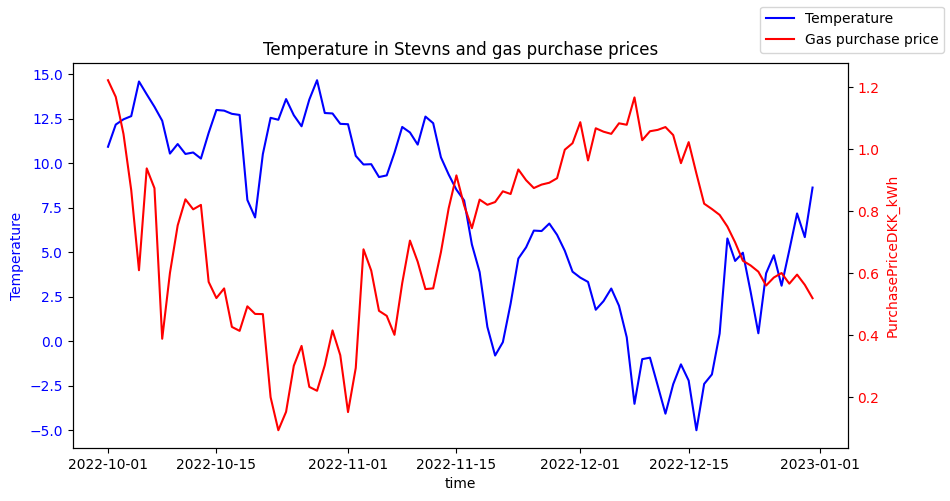

In [126]:
random.seed(12341)

municipality = random.choice(df_weather_trunc["municipality"].unique())
df_weather_trunc = df_weather_trunc.query(f"municipality == '{municipality}'")

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(df_weather_trunc["datetime"], df_weather_trunc["temp"], 
         color='b', label='Temperature')
ax1.set_xlabel("time")
ax1.set_ylabel("Temperature", color="b")
ax1.tick_params(axis="y", labelcolor="b")

ax2 = ax1.twinx()
ax2.plot(df_weather_trunc["datetime"], df_gas_prices_trunc["PurchasePriceDKK_kWh"], 
         color='r', label='Gas purchase price')
ax2.set_ylabel("PurchasePriceDKK_kWh", color="r")
ax2.tick_params(axis="y", labelcolor="r")

fig.legend(loc="upper right")
plt.title(f"Temperature in {municipality} and gas purchase prices")

plt.show()